## Contour analysis and effective diffusivity
**16 March 2020 by MiniUFO**

---
[TOC]

---
### 1. Introduction
In geophysical fluid, tracers are advected followed the motion of the fluid partiles.  As a result, tracer contours are deformed, stretched, or even broken by differential advection.  In the case of a pure adiabatic case, a conservative tracer contour can be used as a fluid container, in which fluid mass cannot go through its border.  Contours can also be used as a coordinate for interesting analyses.

Here we would like to calculate the effective diffusivity proposed by [Nakamura (1996)](https://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281996%29053%3C1524%3ATDMEFA%3E2.0.CO%3B2), defined in a contour-based coordinate.  Basically, we need to tranform a 2D horizontal coordinates into a contour-based coordinate spanning the range (from min value to max value) of a tracer field.

This notebook is based on [xarray](http://xarray.pydata.org/en/stable/) and the recent development of [xgcm](https://github.com/xgcm/xgcm).  It will show that the whole calculation is very easy under the help of these tools.

---

### 2. Theoretical guide
The effective diffusivity in terms of a conservative tracer $q$ is defined as:
$$K_{eff}=\frac{\frac{\partial}{\partial A}\int_{q<q^*} |\nabla q|^2 dS}{\frac{\partial q}{\partial Y}}=\frac{<|\nabla q|^2>_q}{\frac{\partial q}{\partial Y}} \tag{1}$$

where $<\cdot>_q$ is the along-contour average operator.  One may find more specific details in [this book chapter](http://geosci.uchicago.edu/~nnn/Book_Nakamura_PrintPDF.pdf).

---

### 3. Practice using xgcm/xmitgcm
Here for demonstrating purpose, we use potential vorticity (PV) as the conservative tracer $q$ in Eq. (1).  The data are downloaded from [ERA Interim (ECMWF)](https://apps.ecmwf.int/datasets/data/interim-full-daily/levtype=pt/) on isentropic levels.

First, we read in all the PV data at each isentropic levels:

In [1]:
import xarray as xr

dset = xr.open_dataset('../Data/PV.nc')

print(dset)

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 15, longitude: 480)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 265 275 285 300 315 330 ... 430 475 530 600 700 850
    time       datetime64[ns] ...
Data variables:
    pv         (level, latitude, longitude) float32 ...


The PV data extends from 275K to 850K in the stratosphere and covers only one time snapshot at 01 Jan 2010.  Then we use [ContourAnalysisInLatLon](https://github.com/miniufo/GeoApps/blob/master/ContourMethods.py) class to carry out the calculation, which hides all the specific details.  However, we can see the overall procedure very clearly.

In [61]:
import sys
sys.path.append('../../')
from GeoApps.ContourMethods import ContourAnalysisInLatLon
from GeoApps.DiagnosticMethods import Dynamics
from GeoApps.GridUtils import add_latlon_metrics

# Reverse the latitude coordinates in ascending order and add grid
# metrics so that we can use xgcm to perform area-integral
dset, grid = add_latlon_metrics(dset.sortby(dset['latitude'], ascending=True))

tracer = dset.pv

# Calculate squared PV gradient in lat/lon coordinates
grdS = Dynamics(dset, grid).cal_squared_gradient(tracer)


# Construct an analysis class using PV as the tracer
analysis = ContourAnalysisInLatLon(dset, tracer, grid)

# This should be called first to initialize contours from minimum value
# to maximum value (within lat/lon dims) using `N` contours.
N   = 121
ctr = analysis.cal_contours(N, dims=['latitude', 'longitude'])

# Calculate various diagnostics defined in contour-based coordinates
area    = analysis.cal_integral_within_contours(ctr, out_name='intArea')
intgrdS = analysis.cal_integral_within_contours(ctr, grdS, out_name='intgrdS')
latEq   = analysis.cal_equivalent_coords(area)
dgrdSdA = analysis.cal_gradient_wrt_area(intgrdS, area)
dqdA    = analysis.cal_gradient_wrt_area(ctr, area)
Leq2    = analysis.cal_sqared_equivalent_length(dgrdSdA, dqdA)
Lmin    = analysis.cal_minimum_possible_length(latEq)
nkeff   = analysis.cal_normalized_Keff(Leq2, Lmin)

# Collect all these as a xarray.Dataset defined on N contours
origin = xr.merge([ctr, area, intgrdS, latEq, dgrdSdA, dqdA, Leq2, Lmin, nkeff])

print(origin)

<xarray.Dataset>
Dimensions:     (contour: 121, level: 15)
Coordinates:
  * contour     (contour) float64 0.0 1.0 2.0 3.0 ... 117.0 118.0 119.0 120.0
  * level       (level) int32 265 275 285 300 315 330 ... 475 530 600 700 850
    time        datetime64[ns] 2010-01-01
Data variables:
    pv          (level, contour) float64 -4.344e-05 -4.155e-05 ... 0.001355
    intArea     (level, contour) float32 0.0 11237380000.0 ... 510096920000000.0
    intgrdS     (level, contour) float32 0.0 5.780161e-10 ... 2.3945333e-05
    latEq       (level, contour) float32 -90.0 -89.46222 ... 89.50504 90.0
    dintgrdSdA  (level, contour) float32 nan 5.1436908e-20 ... 4.2510215e-19
    dpvdA       (level, contour) float64 nan 1.683e-16 ... 2.105e-15 1.403e-15
    Leq2        (level, contour) float64 nan 1.817e+12 ... 1.375e+11 2.158e+11
    Lmin        (level, contour) float32 -1.7498294 375730.25 ... -1.7498294
    nkeff       (level, contour) float64 nan 12.87 9.832 ... 3.384 1.15 nan


Now we can take a look at the normalized effective diffusivity `nkeff` as:

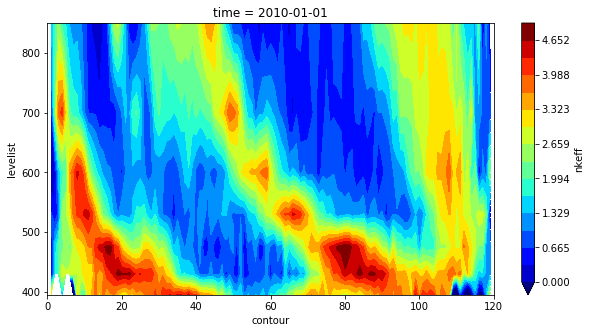

In [62]:
import numpy as np

# Select those levels above ground (400k above)
np.log(origin.nkeff[8:]).plot.contourf(figsize=(10, 5), cmap='jet', levels=16, vmin=0)

This is not so good because the results are defined on evenly-distributed contour space, which is not evenly-distributed in latitude coordinates.  So we interpolate them onto regular latitudes as:

<xarray.Dataset>
Dimensions:     (lat: 181, level: 15)
Coordinates:
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * level       (level) int32 265 275 285 300 315 330 ... 475 530 600 700 850
    time        datetime64[ns] 2010-01-01
Data variables:
    pv          (level, lat) float64 -4.344e-05 -3.713e-05 ... 0.001299 0.001355
    intArea     (level, lat) float64 0.0 3.909e+10 ... 5.101e+14 5.101e+14
    intgrdS     (level, lat) float64 0.0 2.49e-09 ... 2.392e-05 2.395e-05
    latEq       (level, lat) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
    dintgrdSdA  (level, lat) float64 nan 6.76e-20 ... 7.729e-19 4.251e-19
    dpvdA       (level, lat) float64 nan 1.57e-16 ... 4.617e-16 1.403e-15
    Leq2        (level, lat) float64 nan 2.911e+12 ... 3.93e+12 2.158e+11
    Lmin        (level, lat) float64 -1.75 6.986e+05 ... 6.986e+05 -1.75
    nkeff       (level, lat) float64 nan 5.688 6.242 10.58 ... 4.382 8.006 nan


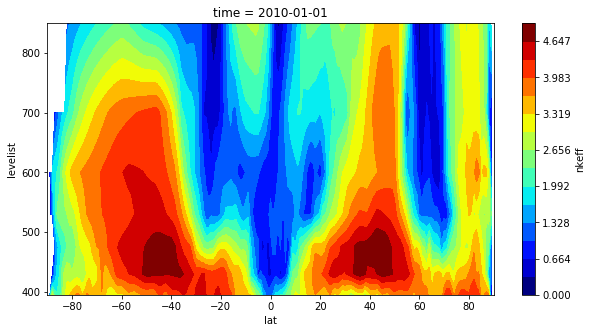

In [63]:
# Interpolate to a set of pre-defined latitudes
preLats = np.linspace(-90, 90, 181)
interp  = analysis.interp_to_dataset(preLats, latEq, origin)

print(interp)

# Select those levels above ground (400k above)
np.log(interp.nkeff[8:]).plot.contourf(figsize=(10, 5), cmap='jet', levels=16, vmin=0)

This looks much better now.  Two enhanced effective diffusivity bands can be clearly identified at midlatitudes, which is similar to the results in [Haynes and Shuckburgh (2000, JAS)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000JD900093).

#### References
1. <https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000JD900093>
2. <http://geosci.uchicago.edu/~nnn/Book_Nakamura_PrintPDF.pdf>
3. <https://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281996%29053%3C1524%3ATDMEFA%3E2.0.CO%3B2>